# The central limit theorem

The Gaussian (or normal) distribution takes two input parameters - the mean $\mu$ and variance $\sigma^2$, and has the following form:
$$ P(x \,|\, \mu, \sigma^2) = \frac{1}{\sqrt{2\pi\sigma^2}} \exp{\Big[-\frac{(x-\mu)^2}{2\sigma^2}\Big]} $$

The central limit theorem (CLT) states that:
*The sum of a large number of independent random variables, each with finite mean and variance, tends towards a Gaussian distribution, **irrespective of the distribution function of the random variable**.*
To be more explicit, if we draw a large number of independent random samples from some unknown distribution and add them all up, then repeat this entire process many times, the distribution of sums will be Gaussian.

If you think about it, this is quite amazing; you start with an almost arbitrary distribution defined by any number of parameters, and just by adding samples, end up with a symmetric distribution defined by just two parameters! 

Why is this useful?
1. **It applies to the mean**.
Note that the procedure for calculating the sample mean $\bar{x}$ involves summing independent random variables.
$$\bar{x} = \frac{1}{N} \sum_{i=1}^N x_i ,$$
Therefore, if we perform multiple, independent evaluations of the mean, the resulting distribution of means will be a Gaussian.
2. The resulting Gaussian distribution will have the same mean as the parent distribution, but **smaller variance**.
In fact, the variance will be smaller by a factor of $N$.
3. **It's easy to assign confidence levels to Gaussian distributions**. For example, one standard deviation from the mean represents a 68% confidence level, whereas two represents 95%.

This notebook is intended to convince you that the CLT *really does work!*
We're going to draw samples from a variety of distributions, and see that in all cases the distribution of means is a Gaussian.

### 1. Draw samples from any old probability distribution

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

## Choose from built-in numpy.random distributions to sample from
from numpy.random import *

dist = uniform # ([low, high, size])
#dist = triangular # (left, mode, height [, size])
#dist = normal # ([loc, scale, size])
#dist = power # (a [, size])
#dist = exponential # ([scale, size])

## Or define your own distribution, e.g.
#def dist(size):
#    x = uniform(0, 1, size)
#    return x * np.exp(-x)

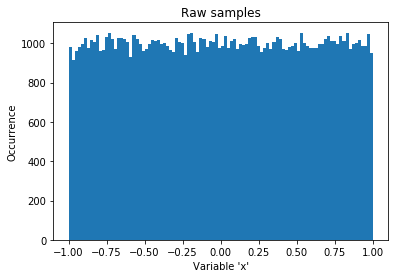

Mean: 0.0009565023002531516
Standard deviation: 0.5768081779588682


In [6]:
## Total number of samples we wish to draw
N = 100000

## Specify a list of arguments for the distribution function selected above
args = [-1, 1, N]

## Draw 'size' samples from the distribution 'dist'
samples = dist(*args)

## Plot the samples we've just drawn
plt.figure("raw")
plt.title("Raw samples")
plt.xlabel("Variable 'x'")
plt.ylabel("Occurrence")
plt.hist(samples, bins=100)

## This should resemble the underlying distribution
plt.show()

## Print the sample mean and standard deviation of this distribution
print "Mean:", samples.mean()
print "Standard deviation:", samples.std(ddof=1)

### 2. Evaluate the mean

For the CLT to apply, we need to generate statistics by summing samples - the sample mean will do nicely.
Let's split our `N` samples into `n` chunks of `m` samples, and take the mean of each chunk.
This should give us `n` data points which, if the CLT applies, should be normally distributed.

#### Problem 1
The uncertainty on the sample mean is given by the *standard error*
$$\alpha = \frac{\sigma_{N-1}}{\sqrt{n}} $$
where $\sigma_{N-1}$ is the standard deviation of raw samples (not means), and $n$ (`n`) is the number of samples used to calculate each mean.
This formula appears to imply that our lowest uncertainty on the mean will be when we take $n = N$ and average over all samples.
* Why is this not the case for this experiment?

#### Note
The $N-1$ in $\sigma_{N-1}$ relates to a correction, introduced by Bessel, when calculating the standard deviation of a *sample* as opposed to the standard deviation of the entire *population* (i.e. that of the parent distribution).
This is also the origin of the `ddof=1` argument in the `np.std()` function.

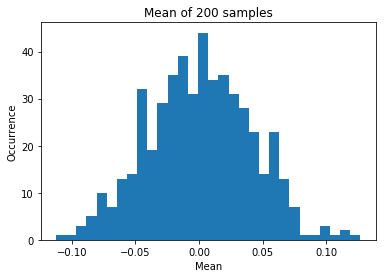

Standard error: 0.04078649740785725


In [7]:
## Split data into equal-sized chunks, so we can take the mean of each chunk
m = 500 # number of chunks - must a factor of N
n = N / m # samples per chunk

## Reshape the samples array so we can average over each column
samples_nm = samples.reshape((n, m))

## Take the mean of every 'm' samples
mean = samples_nm.mean(axis=0)

## Plot the distribution of means
plt.figure("mean")
plt.title("Mean of %d samples" %n)
plt.xlabel("Mean")
plt.ylabel("Occurrence")
plt.hist(mean, bins=30)

## This should resemble a Gaussian
plt.show()

## Print an estimate for the standard error based on the formula above
print "Standard error:", samples.std(ddof=1) / np.sqrt(n)

### 3. Check that a Gaussian fits the resulting distribution

Let's try fitting a Gaussian curve to our distribution. The important thing to note is an absence of structure in the residuals, indicating that the Gaussian is a good fit.

#### Problem 2
Another name for the standard error is the *standard deviation of the mean*.
We calculate this value below, by fitting a Gaussian to the distribution of means.

* By varying `n` and applying the formula for the standard error, check that it agrees with the standard deviation of the mean.

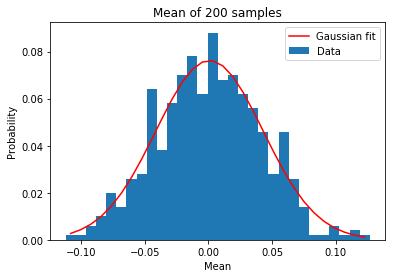

Mean: 0.0008312401772354277
Standard deviation: 0.04224471451747888


In [8]:
## Define a Gaussian function, to be used by scipy for curve fitting
def gaussian(x, *p):
    A, mu, sigma = p # (to do) I ought to constrain A
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

## An initial guess for the parameters 'p'
p0 = [1., samples.mean(), samples.std()]

## Get histogram of means, and bin edges
bins = 30
hist, bin_edges = np.histogram(mean, bins)

## Normalise histogram to obtain probability distribution
hist_sum = np.sum(hist)
hist_norm = [float(h)/hist_sum for h in hist]

## Convert bin edges to bin centers
bin_width = bin_edges[1]-bin_edges[0]
bin_centers = bin_edges[:-1] + bin_width/2.0

## Fit the Gaussian function to our mean data using scipy
popt, pcov = curve_fit(gaussian, bin_centers, hist_norm, p0=p0)
fit = gaussian(bin_centers, *popt)

## Plot the distribution of means with the Gaussian fit
plt.figure("fit")
plt.title("Mean of %d samples" %n)
plt.xlabel("Mean")
plt.ylabel("Probability")
plt.bar(bin_centers, height=hist_norm, width=bin_width, label="Data")
plt.plot(bin_centers, fit, 'r', label="Gaussian fit")
plt.legend()

## This should show that the histogram of means can be fit by a Gaussian
plt.show()

## Print the fitted mean and standard deviation
print "Mean:", popt[1]
print "Standard deviation:", abs(popt[2])

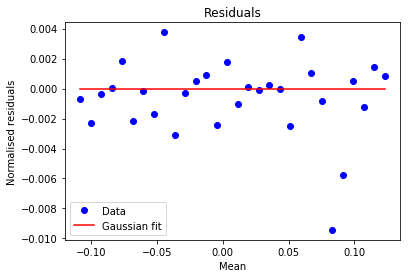

Number of data points above the fitted line: 13
Number of data points below the fitted line: 17


In [9]:
## Let's check that the residuals don't show any structure
residuals = hist_norm - fit

## This is a very rough way of "normalising" the residuals, where I (wrongly) assume that the
## uncertainty in each bin is proportional to the square root of the counts for that bin
normalisation = np.maximum( np.ones(len(residuals)), np.sqrt(hist) ) # can't divide by 0
residuals = residuals / normalisation

plt.figure("res")
plt.title("Residuals")
plt.xlabel("Mean")
plt.ylabel("Normalised residuals")
plt.plot(bin_centers, residuals, 'bo', label="Data")
plt.plot(bin_centers, np.zeros(bins), 'r', label="Gaussian fit")
plt.legend()

plt.show()

print "Number of data points above the fitted line:", (residuals > 0).sum()
print "Number of data points below the fitted line:", (residuals < 0).sum()